In [1]:
%matplotlib inline

# Linear Least-Squares Inversion with Tikhonov Regularization

Here we demonstrate the basics of inverting data with SimPEG by considering a
linear inverse problem. We formulate the inverse problem as a least-squares
optimization problem. For this tutorial, we focus on the following:

    - Defining the forward problem
    - Defining the inverse problem (data misfit, regularization, optimization)
    - Specifying directives for the inversion
    - Recovering a set of model parameters which explains the observations


## Import Modules




In [1]:
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

from SimPEG import (
    simulation,
    maps,
    data_misfit,
    directives,
    optimization,
    regularization,
    inverse_problem,
    inversion,
)

# sphinx_gallery_thumbnail_number = 3

## Defining the Model and Mapping

Here we generate a synthetic model and a mappig which goes from the model
space to the row space of our linear operator.




(-2.0, 2.0)

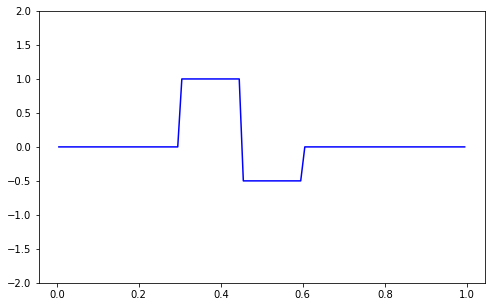

In [2]:
nParam = 100  # Number of model paramters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.vectorCCx > 0.3] = 1.0
true_model[mesh.vectorCCx > 0.45] = -0.5
true_model[mesh.vectorCCx > 0.6] = 0

# Mapping from the model space to the row space of the linear operator
model_map = maps.IdentityMap(mesh)

# Plotting the true model
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(mesh.vectorCCx, true_model, "b-")
ax.set_ylim([-2, 2])

## Defining the Linear Operator

Here we define the linear operator with dimensions (nData, nParam). In practive,
you may have a problem-specific linear operator which you would like to construct
or load here.




Text(0.5, 1.0, 'Columns of matrix G')

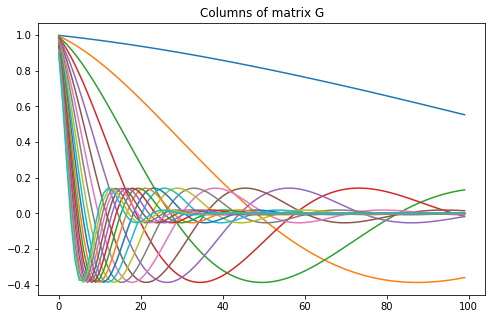

In [3]:
# Number of data observations (rows)
nData = 20

# Create the linear operator for the tutorial. The columns of the linear operator
# represents a set of decaying and oscillating functions.
jk = np.linspace(1.0, 60.0, nData)
p = -0.25
q = 0.25


def g(k):
    return np.exp(p * jk[k] * mesh.vectorCCx) * np.cos(
        np.pi * q * jk[k] * mesh.vectorCCx
    )


G = np.empty((nData, nParam))

for i in range(nData):
    G[i, :] = g(i)

# Plot the columns of G
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
for i in range(G.shape[0]):
    ax.plot(G[i, :])

ax.set_title("Columns of matrix G")

## Defining the Simulation

The simulation defines the relationship between the model parameters and
predicted data.




In [4]:
sim = simulation.LinearSimulation(mesh, G=G, model_map=model_map)

c:\users\u0102388\pyprojects\wavelet-based-inversion\venv\lib\site-packages\SimPEG\simulation.py:547: UserWarning: G has not been implemented for the simulation
  warnings.warn("G has not been implemented for the simulation")


## Predict Synthetic Data

Here, we use the true model to create synthetic data which we will subsequently
invert.




In [5]:
# Standard deviation of Gaussian noise being added
std = 0.01
np.random.seed(1)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, relative_error=std, add_noise=True)

## Define the Inverse Problem

The inverse problem is defined by 3 things:

    1) Data Misfit: a measure of how well our recovered model explains the field data
    2) Regularization: constraints placed on the recovered model and a priori information
    3) Optimization: the numerical approach used to solve the inverse problem




In [6]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(simulation=sim, data=data_obj)

# Define the regularization (model objective function).
reg = regularization.Tikhonov(mesh, alpha_s=1.0, alpha_x=1.0)

# Define how the optimization problem is solved.
opt = optimization.InexactGaussNewton(maxIter=50)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define Inversion Directives

Here we define any directiveas that are carried out during the inversion. This
includes the cooling schedule for the trade-off parameter (beta), stopping
criteria for the inversion and saving inversion results at each iteration.




In [7]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e-4)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit()

# The directives are defined as a list.
directives_list = [starting_beta, target_misfit]

## Setting a Starting Model and Running the Inversion

To define the inversion object, we need to define the inversion problem and
the set of directives. We can then run the inversion.




In [8]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Starting model
starting_model = np.zeros(nParam)

# Run inversion
recovered_model = inv.run(starting_model)

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.86e+02  1.00e+05  0.00e+00  1.00e+05    1.26e+06      0              
   1  1.86e+02  4.68e+04  3.50e-01  4.68e+04    8.00e+04      0              
   2  1.86e+02  3.18e+04  1.35e+00  3.21e+04    5.90e+04      0              
   3  1.86e+02  1.75e+04  5.21e+00  1.85e+04    5.36e+04      0   Skip BFGS  
   4  1.86e+02  1.16e+04  5.18e+00  1.25e+04    8.12e+04      0              
   5  1.86e+02  8.05e+03  8.09e+00  9.55e+03    4.44e+04      0              
   6  1.86e+02  4.39e+03  1.19e+01  6.59e+03    5.39e+04  

## Plotting Results




(-2.0, 2.0)

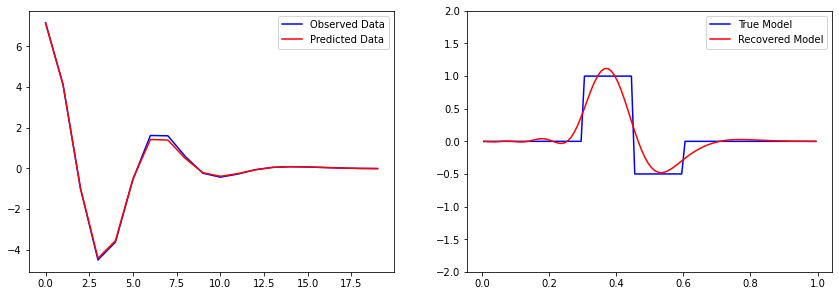

In [9]:
# Observed versus predicted data
fig, ax = plt.subplots(1, 2, figsize=(12 * 1.2, 4 * 1.2))
ax[0].plot(data_obj.dobs, "b-")
ax[0].plot(inv_prob.dpred, "r-")
ax[0].legend(("Observed Data", "Predicted Data"))

# True versus recovered model
ax[1].plot(mesh.vectorCCx, true_model, "b-")
ax[1].plot(mesh.vectorCCx, recovered_model, "r-")
ax[1].legend(("True Model", "Recovered Model"))
ax[1].set_ylim([-2, 2])